# Plot Backend

Plots the APE, RPE and trajectory against ground truth for the final backend output trajectory.

In [93]:
import yaml
import os
import copy
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

from evaluation.evaluation_lib import (
    get_ape_trans, 
    get_ape_rot, 
    get_rpe_trans, 
    get_rpe_rot,
    plot_metric, 
    plot_traj_colormap_ape, 
    plot_traj_colormap_rpe,
    convert_abs_traj_to_rel_traj
)

#%matplotlib inline
#%matplotlib widget
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import mpl_toolkits.mplot3d.art3d as art3d

## Data Locations

Make sure to set the following paths.

`vio_output_dir` is the path to the directory containing `output_*.csv` files obtained from logging a run of SparkVio.

`gt_data_file` is the absolute path to the `csv` file containing ground truth data for the absolute pose at each timestamp of the dataset.

In [155]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
vio_output_dir = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs"
gt_data_file = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/state_groundtruth_estimate0/data.csv"

In [156]:
def rename_pim_df(df):
    """ Renames a DataFrame built from a PIM measurements csv file to be converted to a trajectory.
    
        This is an 'inplace' argument and returns nothing.
    
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={"tx": "x",
                       "ty": "y",
                       "tz": "z"}, inplace=True)

# show coordinate axes
def colored_line_collection(xyz, colors, plot_mode=plot.PlotMode.xy,
                            linestyles="solid", step=2, alpha=1.):
    if len(xyz) / step != len(colors):
        raise PlotException(
            "color values don't have correct length: %d vs. %d" %
            (len(xyz) / step, len(colors)))
    x_idx, y_idx, z_idx = plot.plot_mode_to_idx(plot_mode)
    xs = [[x_1, x_2]
          for x_1, x_2 in zip(xyz[:-1:step, x_idx], xyz[1::step, x_idx])]
    ys = [[x_1, x_2]
          for x_1, x_2 in zip(xyz[:-1:step, y_idx], xyz[1::step, y_idx])]
    if plot_mode == plot.PlotMode.xyz:
        zs = [[x_1, x_2]
              for x_1, x_2 in zip(xyz[:-1:step, z_idx], xyz[1::step, z_idx])]
        segs = [list(zip(x, y, z)) for x, y, z in zip(xs, ys, zs)]
        line_collection = art3d.Line3DCollection(segs, colors=colors,
                                                 alpha=alpha,
                                                 linestyles=linestyles)
    else:
        segs = [list(zip(x, y)) for x, y in zip(xs, ys)]
        line_collection = LineCollection(segs, colors=colors, alpha=alpha,
                                         linestyle=linestyles)
    return line_collection

def draw_coordinate_axes(ax, traj, plot_mode, downsample_ratio=20, marker_scale=1, x_color="r",
                         y_color="g", z_color="b"):
    """
    Draws a coordinate frame axis for each pose of a trajectory.
    :param ax: plot axis
    :param traj: trajectory.PosePath3D or trajectory.PoseTrajectory3D object
    :param plot_mode: PlotMode value
    :param marker_scale: affects the size of the marker (1. * marker_scale)
    :param x_color: color of the x-axis
    :param y_color: color of the y-axis
    :param z_color: color of the z-axis
    """
    if marker_scale <= 0:
        return

    unit_x = np.array([1 * marker_scale, 0, 0, 1])
    unit_y = np.array([0, 1 * marker_scale, 0, 1])
    unit_z = np.array([0, 0, 1 * marker_scale, 1])

    # Transform start/end vertices of each axis to global frame.
    x_vertices = np.array([[p[:3, 3], p.dot(unit_x)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])
    y_vertices = np.array([[p[:3, 3], p.dot(unit_y)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])
    z_vertices = np.array([[p[:3, 3], p.dot(unit_z)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])

    n = len(traj.poses_se3[::downsample_ratio])
    # Concatenate all line segment vertices in order x, y, z.
    vertices = np.concatenate((x_vertices, y_vertices, z_vertices)).reshape(
        (n * 2 * 3, 3))
    # Concatenate all colors per line segment in order x, y, z.
    colors = np.array(n * [x_color] + n * [y_color] + n * [z_color])

    markers = colored_line_collection(vertices, colors, plot_mode, step=2)
    ax.add_collection(markers)
    
def draw_start_and_end(ax, traj, plot_mode):
    """Draw start and end points of the trajectory
    """
    start_pose = traj.poses_se3[0]
    end_pose = traj.poses_se3[-1]
    if plot_mode == plot.PlotMode.xy:
        ax.plot(start_pose[0,3], start_pose[1,3], 'bo')
        ax.plot(end_pose[0,3], end_pose[1,3], 'rx')

## Backend Trajectory

Associate, align and process the trajectory as determined by the backend. Note that this does not include loop closure factors or other optimizations. This is pure VIO.

In [157]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)
gt_df = gt_df[~gt_df.index.duplicated()]

# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref_complete = pandas_bridge.df_to_trajectory(gt_df)

In [158]:
#tracking output pose
output_poses_filename = os.path.join(os.path.expandvars(vio_output_dir), "CameraTrajectory.csv")
output_poses_df = pd.read_csv(output_poses_filename, sep=',', index_col=0)

In [159]:


# Use the backend poses as trajectory.
traj_est_unaligned = pandas_bridge.df_to_trajectory(output_poses_df)
discard_n_start_poses = 0
discard_n_end_poses = 0

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref_complete, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False,
                                       discard_n_start_poses = int(discard_n_start_poses),
                                       discard_n_end_poses = int(discard_n_end_poses))

print("traj_ref: ", traj_ref)
print("traj_est: ", traj_est)

traj_ref:  2816 poses, 14.611m path length, 98.829s duration
traj_est:  2816 poses, 21.058m path length, 98.829s duration


<IPython.core.display.Javascript object>


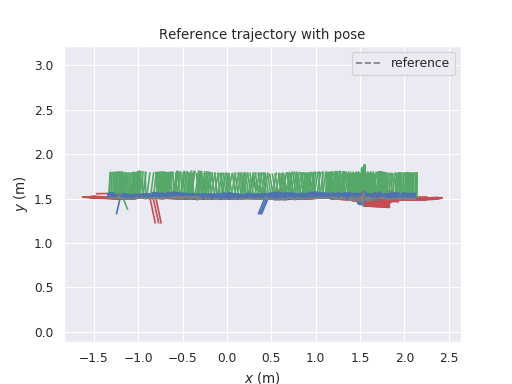

<IPython.core.display.Javascript object>


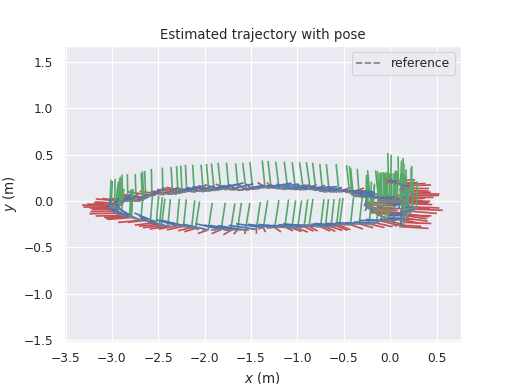

In [160]:
# plot ground truth trajectory with pose
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
draw_coordinate_axes(ax, traj_ref_complete, marker_scale=0.3, downsample_ratio=20, plot_mode=plot_mode)
draw_start_and_end(ax, traj_ref_complete, plot_mode)
plot.traj(ax, plot_mode, traj_ref_complete, '--', "gray", "reference")
plt.title('Reference trajectory with pose')
plt.show()

# plot unaligned trajectory with pose
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
draw_coordinate_axes(ax, traj_est_unaligned, marker_scale=0.3, plot_mode=plot_mode)
draw_start_and_end(ax, traj_est_unaligned, plot_mode)
plot.traj(ax, plot_mode, traj_est_unaligned, '--', "gray", "reference")
plt.title('Estimated trajectory with pose')
plt.show()

<IPython.core.display.Javascript object>


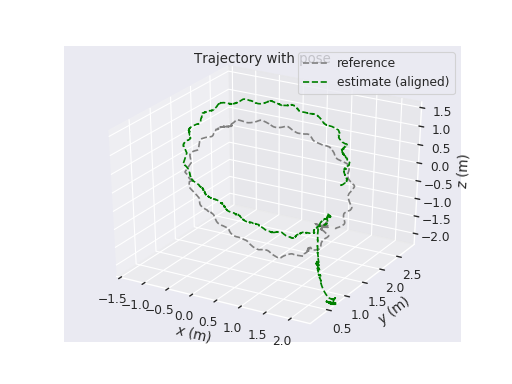

In [161]:
plot_mode = plot.PlotMode.xyz
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)

gt_df_downsampled = gt_df.iloc[:1200:100]


# reference trajectory
traj_ref_downsampled = pandas_bridge.df_to_trajectory(gt_df_downsampled)
#draw_coordinate_axes(ax, traj_ref, plot_mode=plot_mode,marker_scale=0.3)
#draw_coordinate_axes(ax, traj_est, plot_mode=plot_mode,marker_scale=0.3)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj(ax, plot_mode, traj_est, '--', "green", "estimate (aligned)")

plt.title('Trajectory with pose')
plt.show()

## Absolute-Pose-Error Plotting

Plot absolute-pose-error along the entire trajectory. APE gives a good sense of overall VIO performance across the entire trajectory.

### Absolute Translation Errors

The following two plots show 1) VIO's absolute translation errors (ATE) in meters with respect to time, and 2) estimated trajectory color coded by magnitudes of the ATE.

<IPython.core.display.Javascript object>


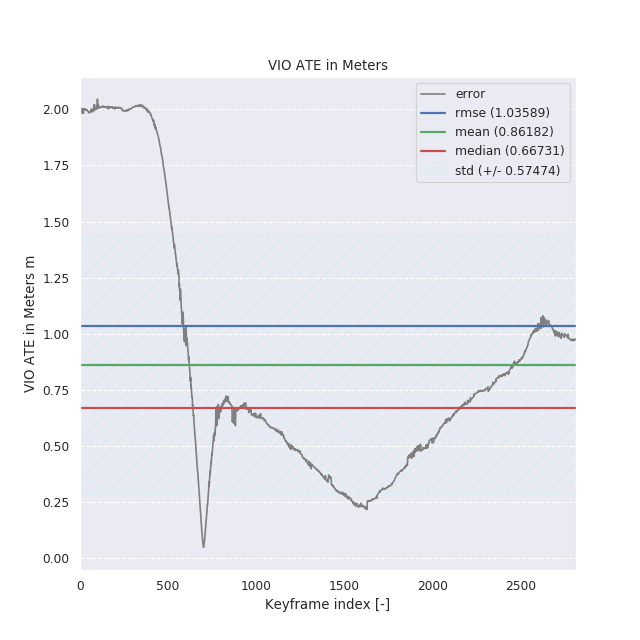

In [162]:
# Plot APE of trajectory rotation and translation parts.
num_of_poses = traj_est.num_poses
traj_est.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))
traj_ref.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))

seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]

ape_tran = get_ape_trans((traj_ref, traj_est))
fig1 = plot_metric(ape_tran, "VIO ATE in Meters")
plt.show()

<IPython.core.display.Javascript object>


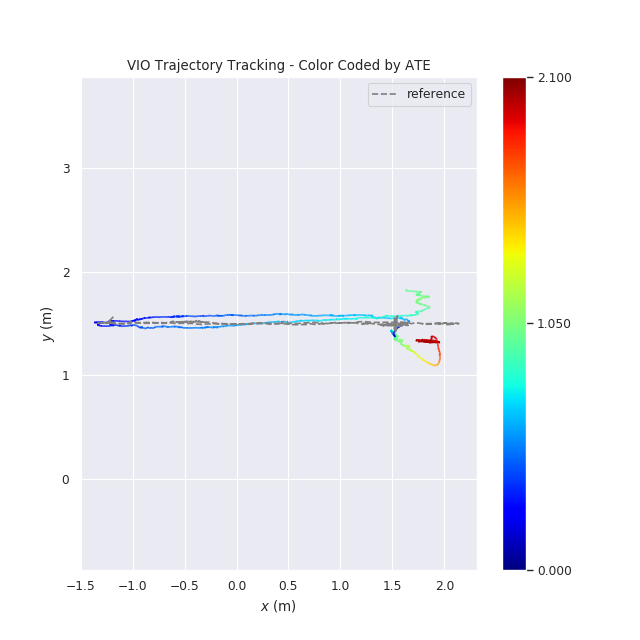

In [163]:
# Plot the ground truth and estimated trajectories against each other with APE overlaid.
fig = plot_traj_colormap_ape(ape_tran, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by ATE")
plt.show()

### Absolute Rotation Errors

The following two plots show 1) VIO's absolute rotation errors (ARE) in meters with respect to time, and 2) estimated trajectory color coded by magnitudes of the ARE. Note that the estimated trajectory used here, unlike ATE, is the unaligned, original estimated trajectory.

<IPython.core.display.Javascript object>


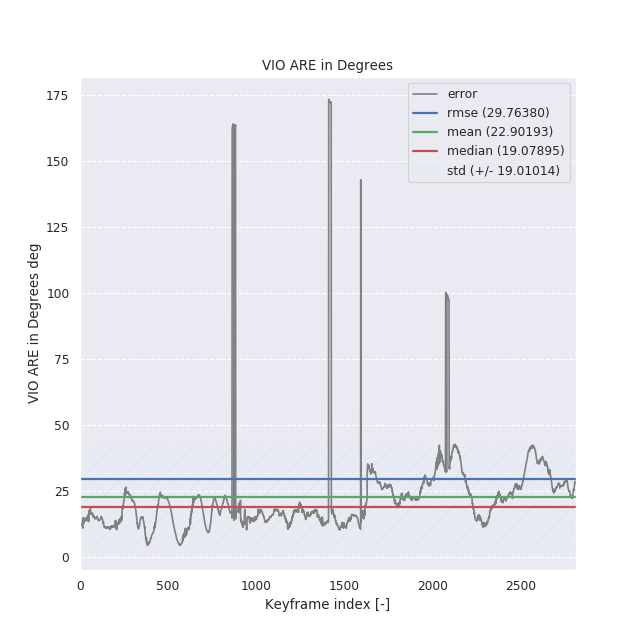

In [164]:
# Plot ARE
traj_est_unaligned.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))

ape_rot = get_ape_rot((traj_ref, traj_est_unaligned))
fig2 = plot_metric(ape_rot, "VIO ARE in Degrees")
plt.show()

<IPython.core.display.Javascript object>


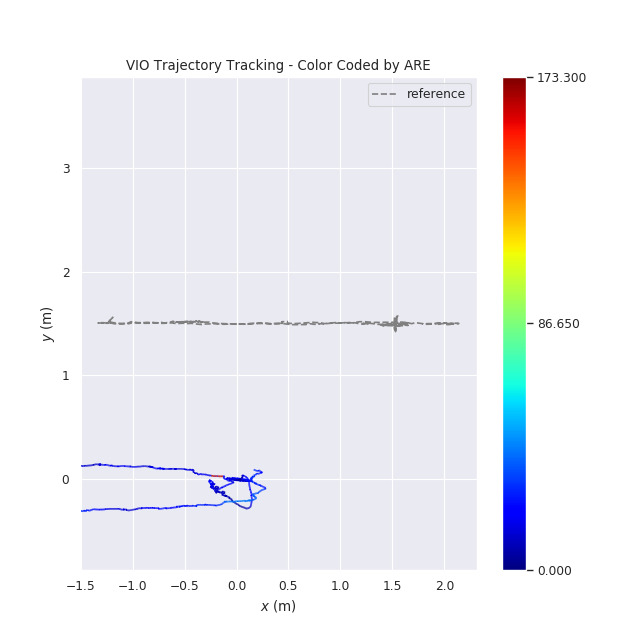

In [165]:
# Plot the ground truth and estimated trajectories against each other with APE overlaid.
fig2 = plot_traj_colormap_ape(ape_rot, traj_ref, traj_est_unaligned,
                             plot_title="VIO Trajectory Tracking - Color Coded by ARE")
plt.show()

## Relative-Pose-Error Plotting

Plot relative-pose-error along the entire trajectory. RPE gives a good sense of overall VIO performance from one frame to the next.

In [166]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe_rot((traj_ref, traj_est))
rpe_tran = get_rpe_trans((traj_ref, traj_est))

### Relative Translation Errors

<IPython.core.display.Javascript object>


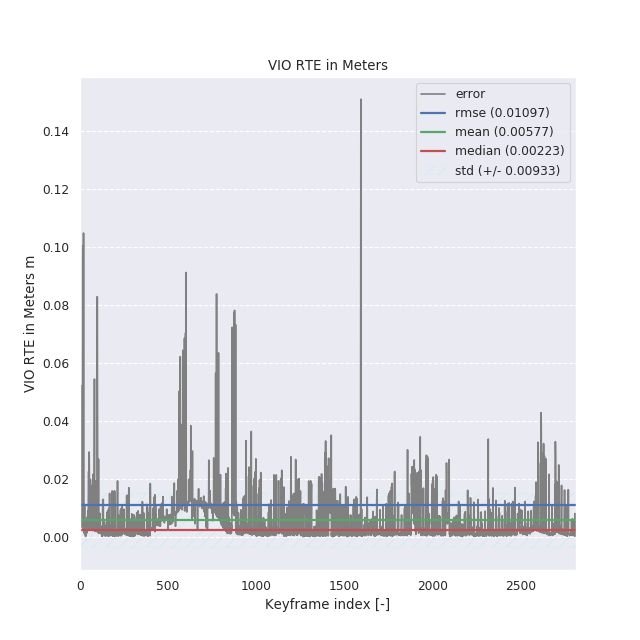

<IPython.core.display.Javascript object>


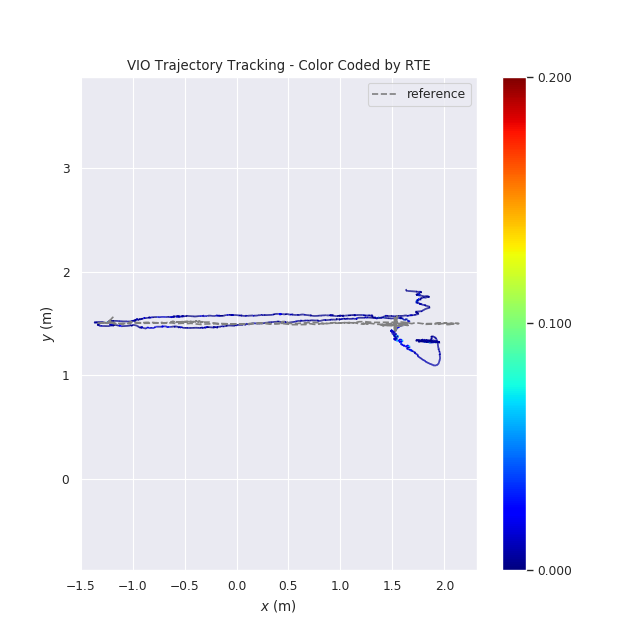

In [167]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

fig1 = plot_metric(rpe_tran, "VIO RTE in Meters")
fig2 = plot_traj_colormap_rpe(rpe_tran, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RTE")
plt.show()

### Relative Rotation Errors

<IPython.core.display.Javascript object>


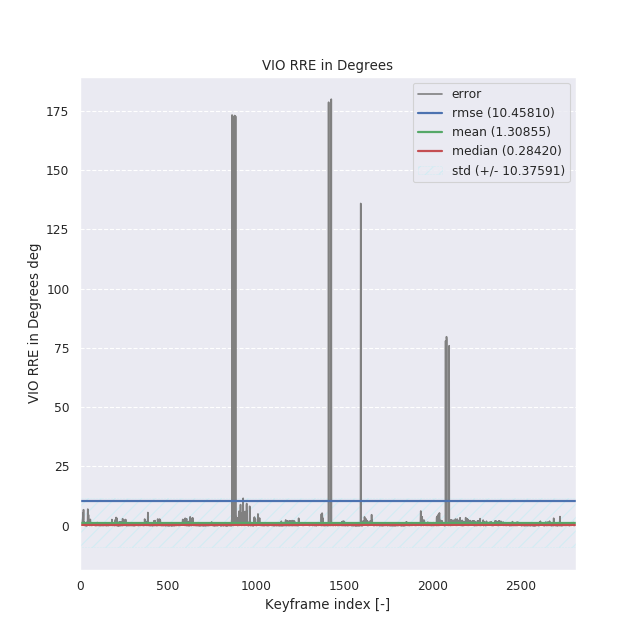

<IPython.core.display.Javascript object>


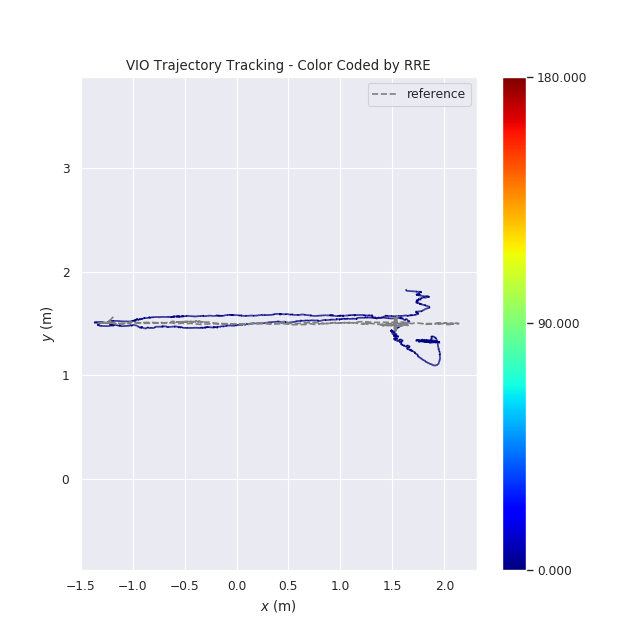

In [168]:
fig1 = plot_metric(rpe_rot, "VIO RRE in Degrees")
fig2 = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RRE")
plt.show()

<IPython.core.display.Javascript object>


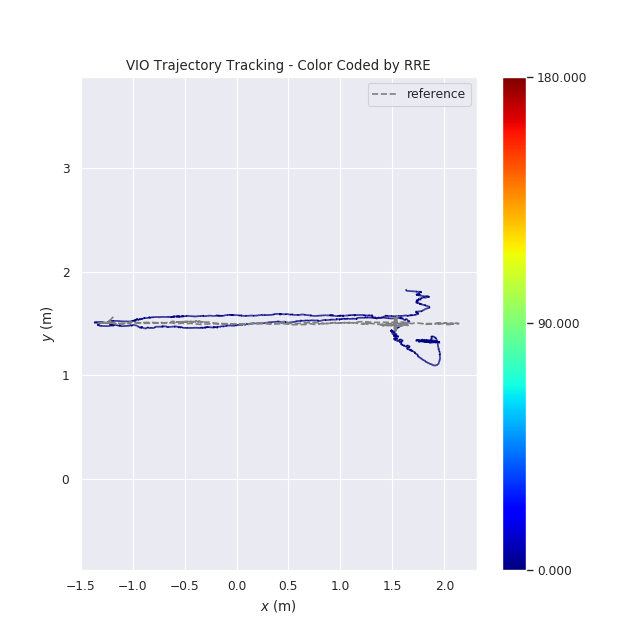

In [169]:
fig = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RRE")
plt.show()

## Trajectory Plotting

Plot the aligned and associated estimated trajectory against ground truth.

<IPython.core.display.Javascript object>


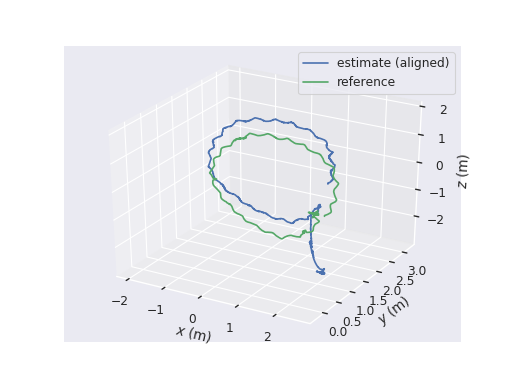

In [170]:
# Plot the trajectories for quick error visualization.

fig = plt.figure()
traj_by_label = {
    #"estimate (unaligned)": traj_est_unaligned,
    "estimate (aligned)": traj_est,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz, title="PIM Trajectory Tracking in 3D")
plt.show()

## IMU initializeing data

### dR

In [481]:
#timestamp,dR_x,dR_y,dR_z,dV_x,dV_y,dV_z,dP_x,dP_y,dP_z,scale,dt,g_x,g_y,g_z

<IPython.core.display.Javascript object>


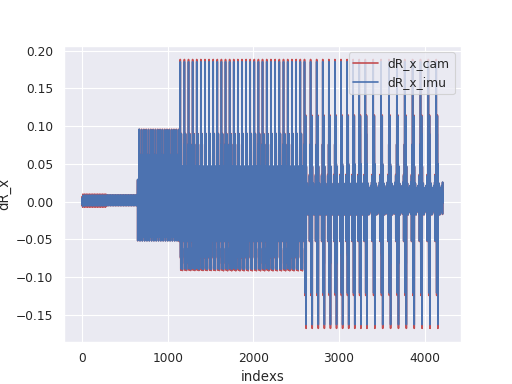

<IPython.core.display.Javascript object>


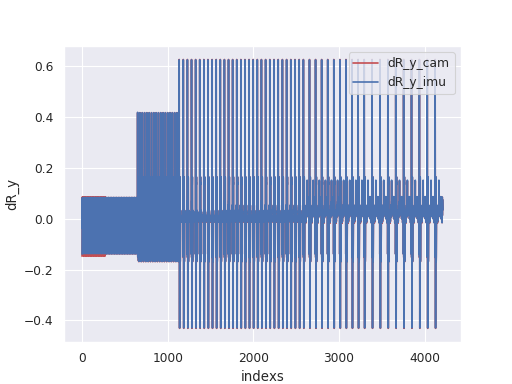

<IPython.core.display.Javascript object>


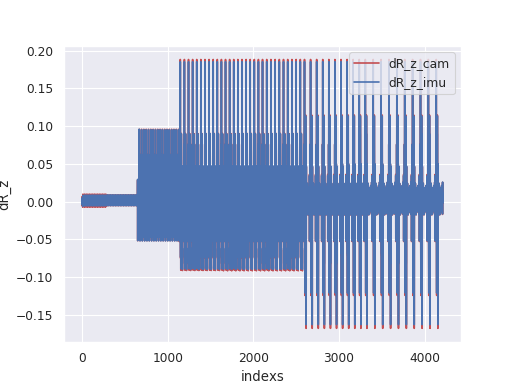

In [196]:
imu_init_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/init_imu_data.csv"
imu_init_df = pd.read_csv(imu_init_filename, sep=',', index_col=0)

imu_init_df_1=imu_init_df[imu_init_df.index == 'cam']
imu_init_df_2=imu_init_df[imu_init_df.index == 'imu']


plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dR_x'], 'r', label='dR_x_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dR_x'], 'b', label='dR_x_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dR_x')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dR_y'], 'r', label='dR_y_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dR_y'], 'b', label='dR_y_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dR_y')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dR_x'], 'r', label='dR_z_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dR_x'], 'b', label='dR_z_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dR_z')
plt.show()


### dV

<IPython.core.display.Javascript object>


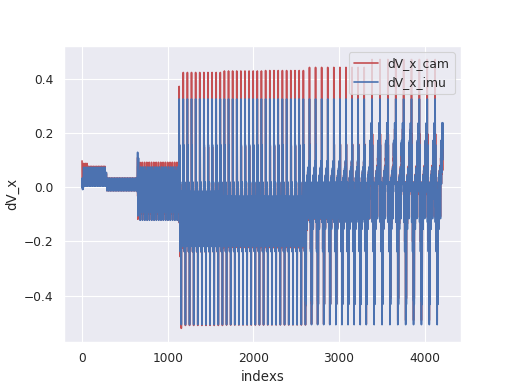

<IPython.core.display.Javascript object>


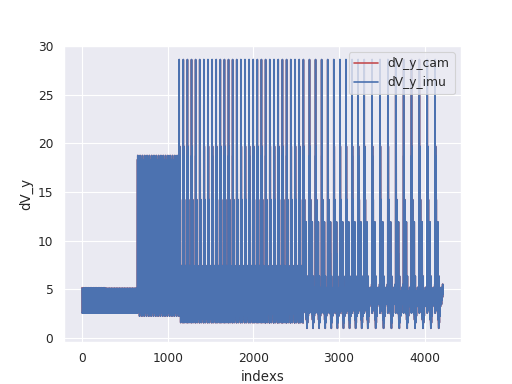

<IPython.core.display.Javascript object>


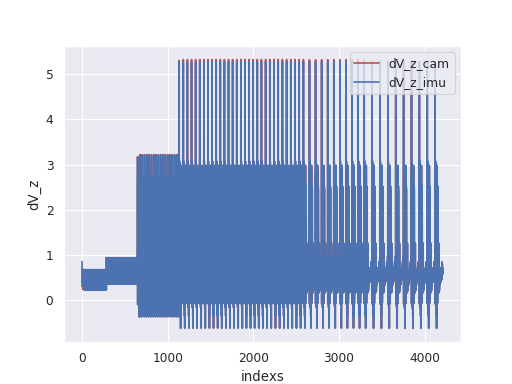

In [197]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dV_x'], 'r', label='dV_x_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dV_x'], 'b', label='dV_x_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dV_x')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dV_y'], 'r', label='dV_y_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dV_y'], 'b', label='dV_y_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dV_y')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dV_z'], 'r', label='dV_z_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dV_z'], 'b', label='dV_z_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dV_z')
plt.show()

### scale

<IPython.core.display.Javascript object>


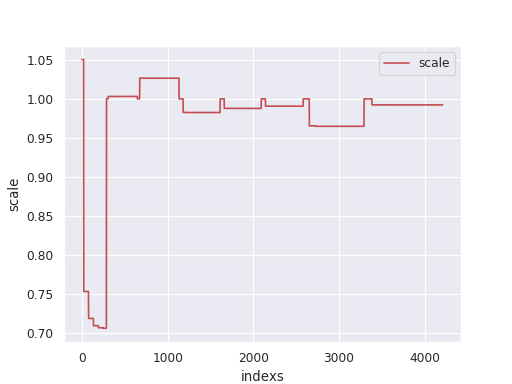

In [198]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['scale'], 'r', label='scale')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('scale')
plt.show()

### dt

<IPython.core.display.Javascript object>


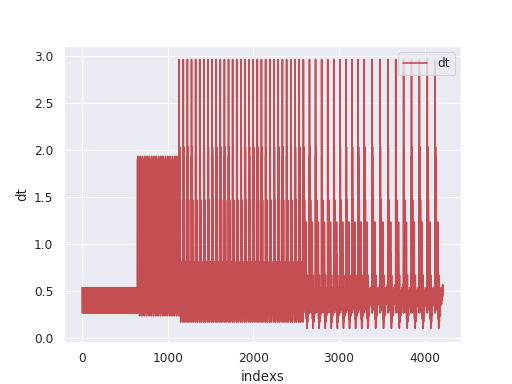

In [199]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dt'], 'r', label='dt')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dt')
plt.show()

### dP

<IPython.core.display.Javascript object>


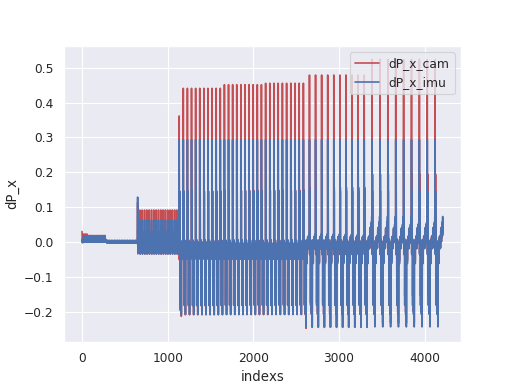

<IPython.core.display.Javascript object>


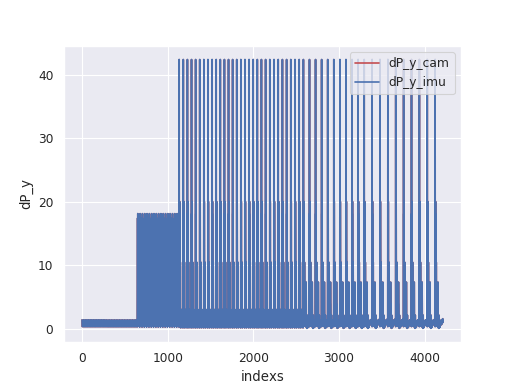

<IPython.core.display.Javascript object>


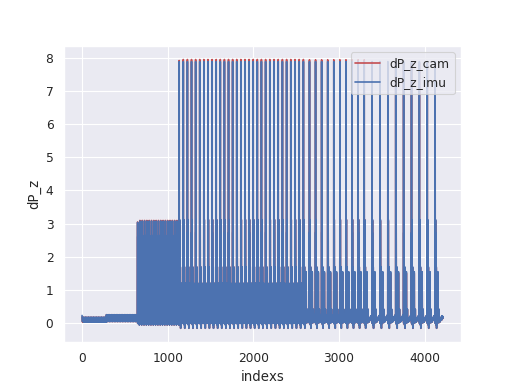

In [200]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dP_x'], 'r', label='dP_x_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dP_x'], 'b', label='dP_x_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dP_x')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dP_y'], 'r', label='dP_y_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dP_y'], 'b', label='dP_y_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dP_y')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dP_z'], 'r', label='dP_z_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dP_z'], 'b', label='dP_z_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dP_z')
plt.show()

### g

<IPython.core.display.Javascript object>


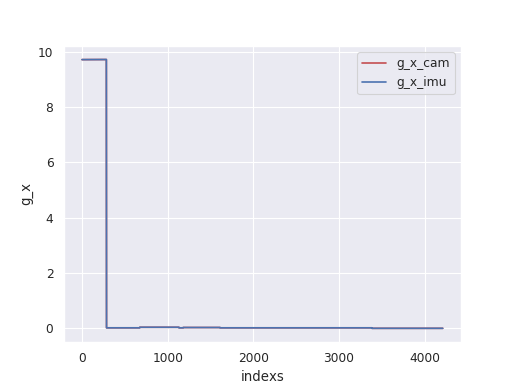

<IPython.core.display.Javascript object>


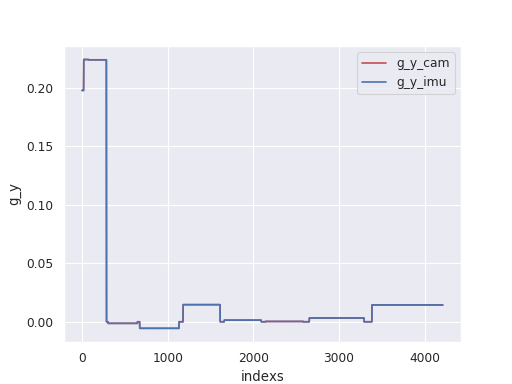

<IPython.core.display.Javascript object>


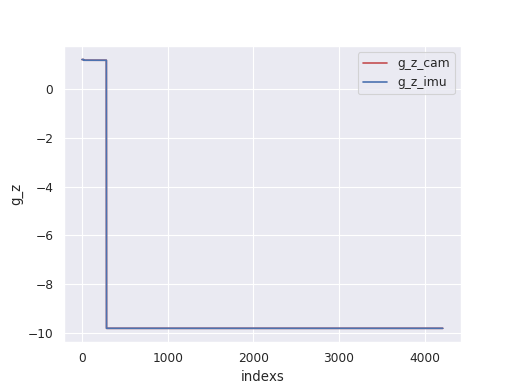

In [201]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['g_x'], 'r', label='g_x_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['g_x'], 'b', label='g_x_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('g_x')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['g_y'], 'r', label='g_y_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['g_y'], 'b', label='g_y_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('g_y')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['g_z'], 'r', label='g_z_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['g_z'], 'b', label='g_z_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('g_z')
plt.show()

## PIM Plotting

Plot preintegrated-imu-measurement estimates of current state over time. This comes in as a trajectory. The plots of error serve to help visualize the error in pim values over time.

Note that these pim values are built off the backend's estimation, not off of ground truth.

In [202]:
pim_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/poses_pim.csv"
pim_df = pd.read_csv(pim_filename, sep=',', index_col=0)
rename_pim_df(pim_df)

#gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)
#output_poses_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/poses_vio.csv"
output_poses_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/state_groundtruth_estimate0/data.csv"
gt_df = pd.read_csv(output_poses_filename, sep=',', index_col=0)
gt_df = gt_df[~gt_df.index.duplicated()]
# TODO: Add relative angle comparison plot between IMU and mono RANSAC

scale_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/scale.csv"
scale_df = pd.read_csv(scale_filename, sep=',', index_col=0)
print(scale_df['scale'].unique())

[1.         1.0504365  1.00307507 1.02644884 0.98243779 0.98770397
 0.99056469 0.96473379 0.99220285]


In [203]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
# traj_est_unassociated = file_interface.read_swe_csv_trajectory(ransac_mono_filename)
traj_est_unaligned = pandas_bridge.df_to_trajectory(pim_df)

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False)

print("traj_ref: ", traj_ref)
print("traj_est: ", traj_est)

traj_ref:  2721 poses, 14.164m path length, 92.899s duration
traj_est:  2721 poses, 19.586m path length, 92.898s duration


### imu gyro and acc measurements

In [204]:
from scipy.spatial.transform import Rotation as R

timeshift = 0.020  #t_imu = t_cam + timeshift

input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 - timeshift
print(imu_data_df)#imu_data_df.index


tracking_pose_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/poses_vio.csv"
track_df = pd.read_csv(tracking_pose_filename, sep=',', index_col=0)
track_df = track_df[~track_df.index.duplicated()]
track_df.index = track_df.index/1e9
print(track_df)

class IMU_POINT:
    def __init__(self,t,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z):
        self.t = t
        self.a = np.array([acc_x,acc_y,acc_z])
        self.w = np.array([gyro_x,gyro_y,gyro_z])
        
class IMU_Pregrated:
    def __init__(self, input_bias_gyro, input_bias_acc, input_noise):
        self.bias_gyro = input_bias_gyro
        self.bias_acc = input_bias_acc
        self.noise = input_noise
        self.accelation = [0,0,0]
        self.angVel = [0,0,0]
        self.dR =  np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        self.dV = [0,0,0]
        self.dP = [0,0,0]
        self.dt = 0
        self.avgA = [0,0,0]
        self.avgW = [0,0,0]
        
    def IntegrateNewMeasurement(self, acc, angVel, dt):
        acc = acc - self.bias_gyro
        angVel = angVel - self.bias_acc

        self.avgA = (np.dot(self.dt, self.avgA) + np.dot(self.dR, acc)*dt)/(self.dt+ dt)
        self.avgW = (np.dot(self.dt, self.avgW) + np.dot(angVel,dt))/(self.dt + dt)
        
        self.dP = self.dP + np.dot(self.dV, dt) + 0.5*np.dot(self.dR, acc)*dt*dt
        self.dV = self.dV + np.dot(self.dR, acc)*dt
        
        #delta =  angVel * dt;
        #dR = NormalizeRotation(dR*dRi.deltaR);

        self.dt = self.dt + dt
        
#preintegrated imu in frame pose
first_im=0
for idx_imu in imu_data_df.index:
    if idx_imu < track_df.index[0]:
        first_im = first_im+1
        
print(first_im)

input_bias_gyro= [0.0034846148835837943,0.010798019810901362,0.029062881375811041] 
input_bias_acc = [0.090057461959824101,0.17379261754407893,0.020827386673560953]
input_noise = [9.0e-05,0.0008745,0.0001079,0.000918493]#noiseGyro, noiseAcc, GyroWalk,AccWalk

for idx_cam in track_df.index:
    vec_imu = []
    mvImuFrom = IMU_Pregrated(input_bias_gyro, input_bias_acc, input_noise)
    while(imu_data_df.index[first_im] < idx_cam):
        imu_d = IMU_POINT(imu_data_df.index[first_im],
                          imu_data_df['a_RS_S_x [m s^-2]'].get(imu_data_df.index[first_im]),
                          imu_data_df['a_RS_S_y [m s^-2]'].get(imu_data_df.index[first_im]),
                          imu_data_df['a_RS_S_z [m s^-2]'].get(imu_data_df.index[first_im]),
                          imu_data_df['w_RS_S_x [rad s^-1]'].get(imu_data_df.index[first_im]),
                          imu_data_df['w_RS_S_y [rad s^-1]'].get(imu_data_df.index[first_im]),
                          imu_data_df['w_RS_S_z [rad s^-1]'].get(imu_data_df.index[first_im]))
        
        first_im  = first_im+1
        vec_imu.append(imu_d)
    #print(len(vec_imu))
    #preintegrated imu
    n = len(vec_imu)
    if(n>0):
        print(len(vec_imu))
        for i in range(n):
            if i>0 and i < (n-1):
                tstep = vec_imu[i+1].t - vec_imu[i].t
                acc = (vec_imu[i+1].a + vec_imu[i].a)*0.5
                angVel = (vec_imu[i+1].w - vec_imu[i].w)*0.5
                mvImuFrom.IntegrateNewMeasurement(acc, angVel, tstep)
    
    
        
        
        

                 w_RS_S_x [rad s^-1]  w_RS_S_y [rad s^-1]  \
#timestamp [ns]                                             
1.287732e+06                0.003232             0.090971   
1.287732e+06                0.003222             0.090975   
1.287732e+06                0.003228             0.090975   
1.287732e+06                0.003235             0.090972   
1.287732e+06                0.003231             0.090976   
...                              ...                  ...   
1.287835e+06                0.022936             0.078846   
1.287835e+06                0.027852             0.086650   
1.287835e+06                0.031539             0.093857   
1.287835e+06                0.035840             0.099259   
1.287835e+06                0.040766             0.104048   

                 w_RS_S_z [rad s^-1]  a_RS_S_x [m s^-2]  a_RS_S_y [m s^-2]  \
#timestamp [ns]                                                              
1.287732e+06                0.062422          -0.0

13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
13
14
13
14
14
13
14
13
14
13
14
13
14
1

### plot imu data

<IPython.core.display.Javascript object>


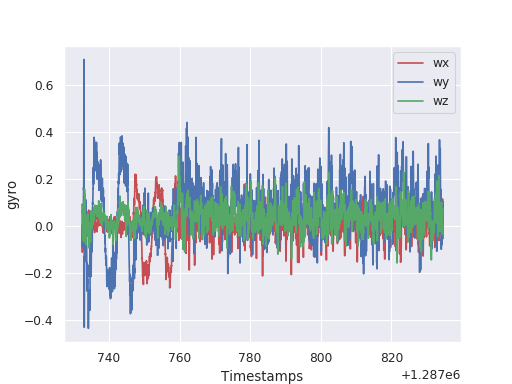

<IPython.core.display.Javascript object>


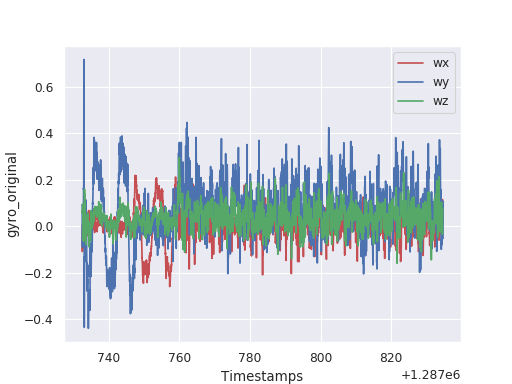

In [205]:
timeshift = 0.020  #t_imu = t_cam + timeshift
input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 - timeshift

#gyro rectify by scale-misalignment
plt.figure()
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_x [rad s^-1]'], 'r', label='wx')
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_y [rad s^-1]'], 'b', label='wy')
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_z [rad s^-1]'], 'g', label='wz')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('gyro')
plt.show()

#gyro original
input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data_original.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 + timeshift

plt.figure()
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_x [rad s^-1]'], 'r', label='wx')
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_y [rad s^-1]'], 'b', label='wy')
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_z [rad s^-1]'], 'g', label='wz')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('gyro_original')
plt.show()

<IPython.core.display.Javascript object>


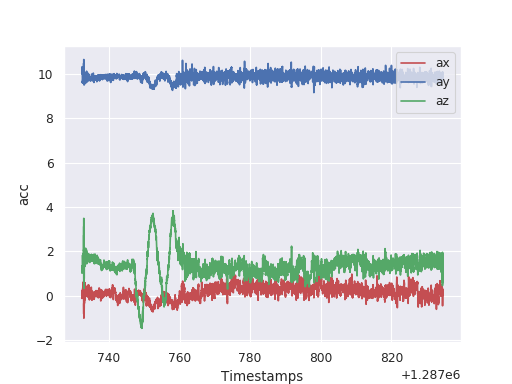

<IPython.core.display.Javascript object>


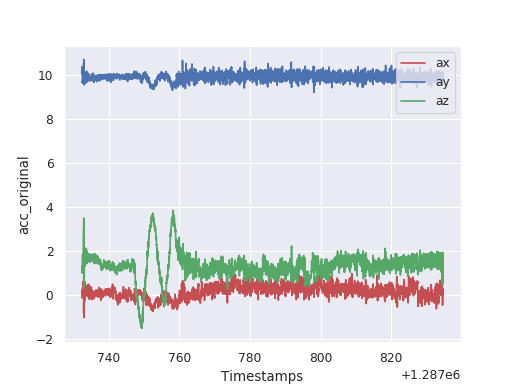

In [221]:
timeshift = 0.020  #t_imu = t_cam + timeshift
input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 - timeshift

#acc rectify by scale-misalignment
plt.figure()
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_x [m s^-2]'], 'r', label='ax')
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_y [m s^-2]'], 'b', label='ay')
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_z [m s^-2]'], 'g', label='az')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('acc')
plt.show()


#acc original
input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data_original.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 + timeshift

plt.figure()
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_x [m s^-2]'], 'r', label='ax')
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_y [m s^-2]'], 'b', label='ay')
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_z [m s^-2]'], 'g', label='az')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('acc_original')
plt.show()


### Relative Angles
This plot compares the relative angles between GT and PIM outputs.

<IPython.core.display.Javascript object>


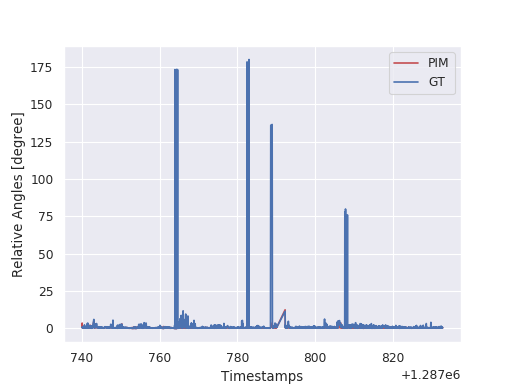

In [222]:
# Convert to relative traj
traj_ref_rel = convert_abs_traj_to_rel_traj(traj_ref, up_to_scale=False)
traj_est_rel = convert_abs_traj_to_rel_traj(traj_est, up_to_scale=False)

# Plot the PIM angles
PIM_angles = []
PIM_angles_timestamps = []
for i in range(len(traj_est_rel._poses_se3)):
    PIM_angles_timestamps.append(traj_est_rel.timestamps[i])
    # quaternion to axisangle
    rotm = traj_est_rel._poses_se3[i][0:3,0:3]
    r = R.from_dcm(rotm)
    
    rot_vec = r.as_rotvec()
    PIM_angles.append(np.linalg.norm(rot_vec)*180/3.14)


# Plot the GT angles
gt_angles = []
gt_angles_timestamps = []
for i in range(len(traj_ref_rel._poses_se3)):
    gt_angles_timestamps.append(traj_ref_rel.timestamps[i])
    # rotation matrix to axisangle
    rotm = traj_ref_rel._poses_se3[i][0:3,0:3]
    r = R.from_dcm(rotm)
    
    rot_vec = r.as_rotvec()
    gt_angles.append(np.linalg.norm(rot_vec)*180/3.14)

    
plt.figure()
plt.plot(PIM_angles_timestamps, PIM_angles, 'r', label='PIM')
plt.plot(gt_angles_timestamps, gt_angles, 'b',  label='GT')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('Relative Angles [degree]')

plt.show()

In [223]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe_rot((traj_ref, traj_est))
rpe_tran = get_rpe_trans((traj_ref, traj_est))

<IPython.core.display.Javascript object>


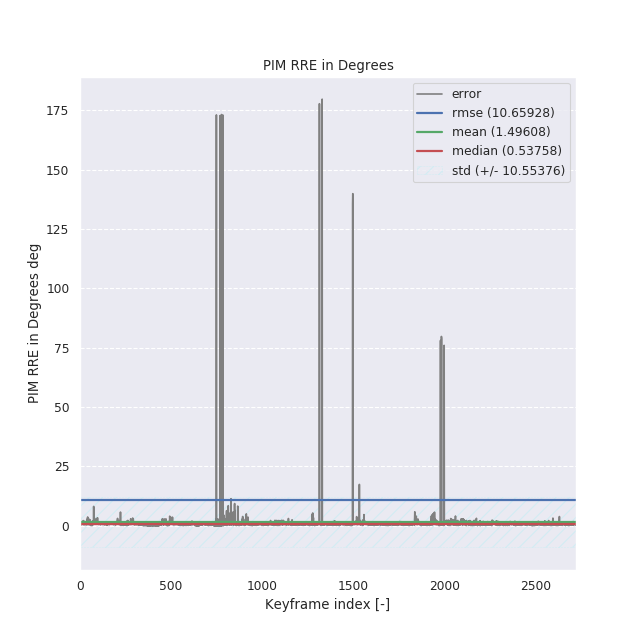

<IPython.core.display.Javascript object>


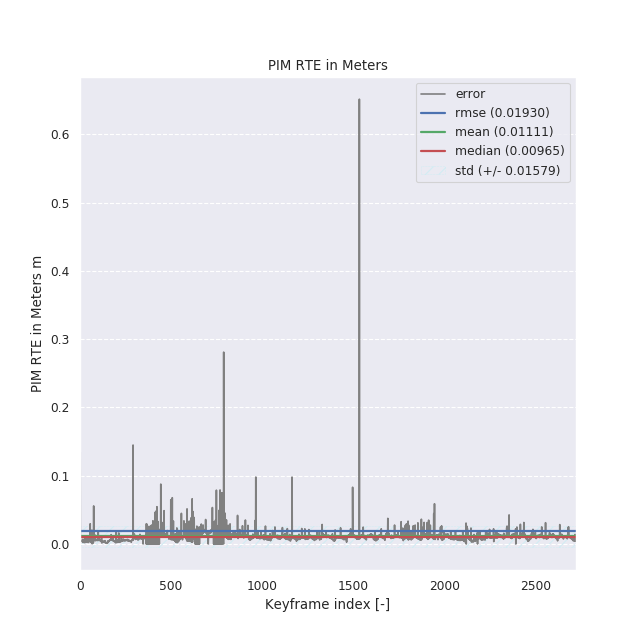

In [227]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_metric(rpe_rot, "PIM RRE in Degrees")
plot_metric(rpe_tran, "PIM RTE in Meters")
plt.show()

<IPython.core.display.Javascript object>


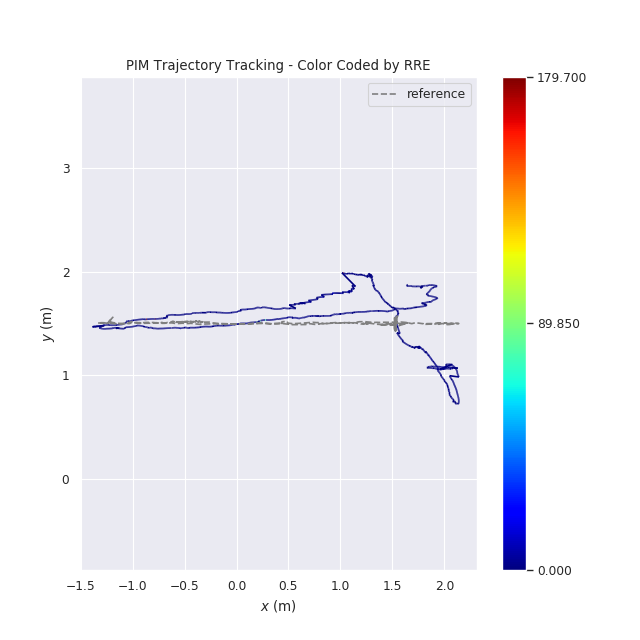

In [225]:
fig = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="PIM Trajectory Tracking - Color Coded by RRE")
plt.show()

<IPython.core.display.Javascript object>


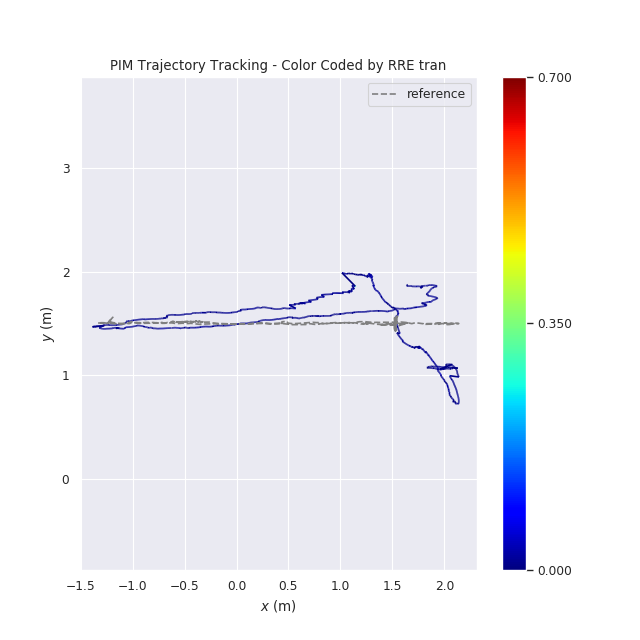

In [217]:
fig = plot_traj_colormap_rpe(rpe_tran, traj_ref, traj_est,
                             plot_title="PIM Trajectory Tracking - Color Coded by RRE tran")
plt.show()

# Smart Factors
Plot smart factors vs. time

<IPython.core.display.Javascript object>


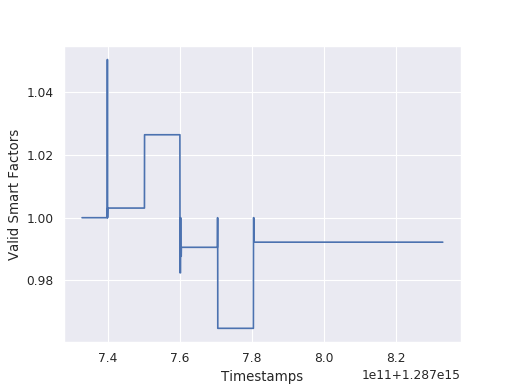

                     scale
#timestamp                
1287732939963078  1.000000
1287732973283755  1.000000
1287733006604380  1.000000
1287733039925005  1.000000
1287733073245630  1.000000
...                    ...
1287832768566309  0.992203
1287832801886934  0.992203
1287832835207559  0.992203
1287832868528184  0.992203
1287832901848809  0.992203

[2976 rows x 1 columns]


In [212]:
#output_sf_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_smartFactors.csv")
output_sf_filename ="/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/scale.csv"
output_sf_df = pd.read_csv(output_sf_filename, sep=',', index_col=0)
fig = plt.figure()
print(output_sf_df)

#plt.plot(output_sf_df.timestamp_kf/1e9, output_sf_df.numValid)
plt.plot(output_sf_df["scale"])
plt.ylabel('Valid Smart Factors')
plt.xlabel('Timestamps')
plt.show()

# Biases
Plot biases of gyro and accelerometer

<IPython.core.display.Javascript object>


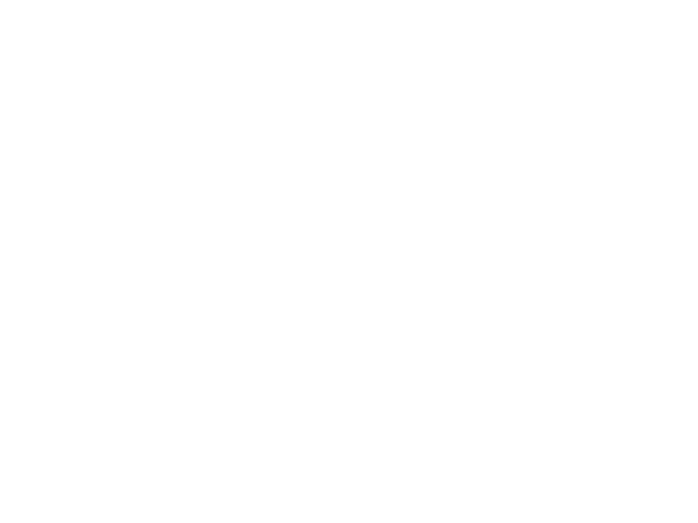

AttributeError: 'DataFrame' object has no attribute 'bgx'

In [190]:
fig = plt.figure()
plt.plot(output_poses_df.index, output_poses_df.bgx)
plt.plot(output_poses_df.index, output_poses_df.bgy)
plt.plot(output_poses_df.index, output_poses_df.bgz)
plt.ylabel('Gyro Biases')
plt.xlabel('Timestamps')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(output_poses_df.index, output_poses_df.bax)
plt.plot(output_poses_df.index, output_poses_df.bay)
plt.plot(output_poses_df.index, output_poses_df.baz)
plt.ylabel('Acceleration Biases')
plt.xlabel('Timestamps')
plt.legend()
plt.show()